In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import arviz as az

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
az.style.use('arviz-darkgrid')

## Non-Markovian methods

### Grid Computing

In [3]:
def posterior_grid(grid_points = 50, heads = 6, tails = 9):
    """
    Coin-fliping problem에 대해 Grid Computing
    """
    grid = np.linspace(0, 1, grid_points)
    prior = np.repeat(1/grid_points, grid_points) # uniform 분포
    likelihood = stats.binom.pmf(heads, heads+tails, grid)
    """
    heads : 앞면이 나온 횟수, heads + tails : 전체 횟수
    """
    posterior = likelihood * prior
    posterior /= posterior.sum()
    return grid, posterior

Text(0.5, 0, 'Θ')

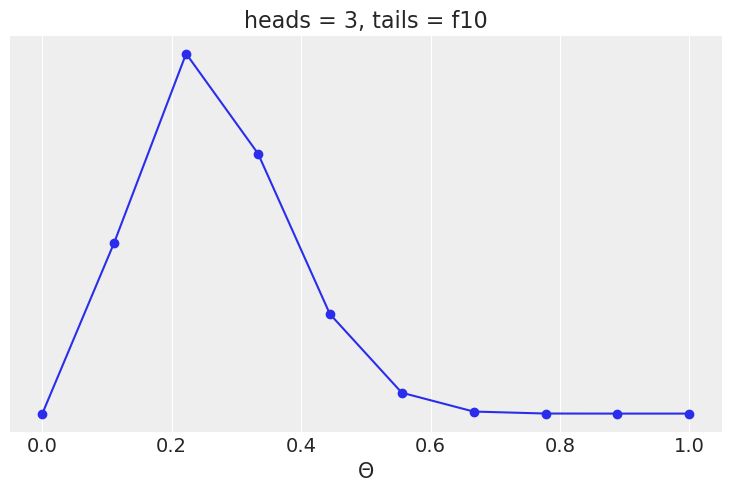

In [4]:
data = np.repeat([0, 1], (10, 3)) # 0이 10개, 1이 3개인 배열 구성
points = 10
h = data.sum()
t = len(data) - h
grid, posterior = posterior_grid(points, h, t)

plt.plot(grid, posterior, 'o-')

plt.title(f'heads = {h}, tails = f{t}')
plt.yticks([])
plt.xlabel('Θ')

### Quadratic method
Posterior를 Gaussian 분포로 근사하는 방법

In [5]:
with pm.Model() as normal_approximation:
    p = pm.Beta('p', 1, 1)
    w = pm.Binomial('w', n = 1, p = p, observed = data)
    mean_q = pm.find_MAP()
    std_q = ((1/pm.find_hessian(mean_q, vars=[p]))**0.5)[0]

In [6]:
mean_q['p'], std_q

(array(0.23076923), array([0.11685454]))

Gaussian 분포의 경우 mode와 mean이 똑같다. 따라서 posterior 의 mode를 가우시안 분포의 평균으로 사용가능.  
그리고 Hessian Matrix를 이용하여 posterior의 표준편차를 계산가능

([], [])

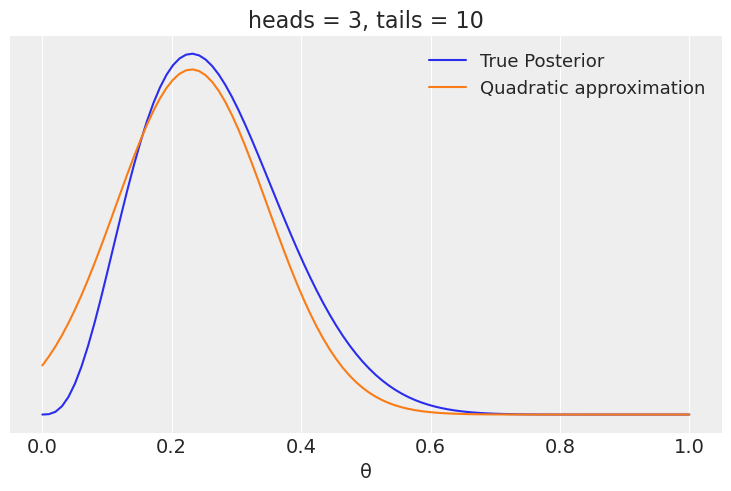

In [7]:
# analytical calculation
x = np.linspace(0, 1, 100)
plt.plot(x, stats.beta.pdf(x, h+1, t+1), label = 'True Posterior')
plt.legend(fontsize = 13)

# quadratic approximation
plt.plot(x, stats.norm.pdf(x, mean_q['p'], std_q), label = 'Quadratic approximation')
plt.legend(fontsize = 13)

plt.title(f'heads = {h}, tails = {t}')
plt.xlabel('θ', fontsize=14)
plt.yticks([])

## Markovian methods

### Monte Carlo

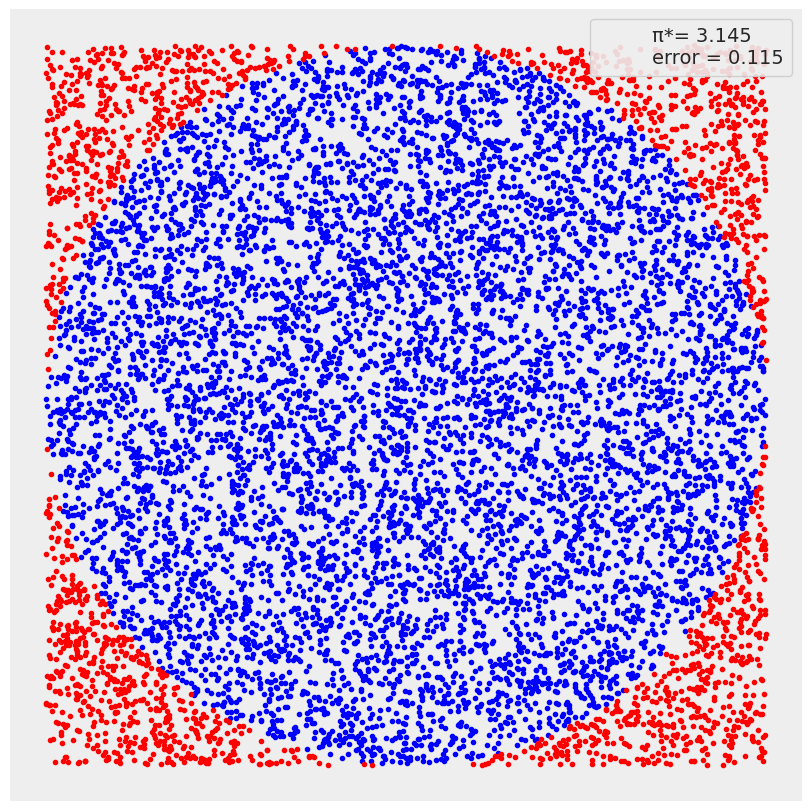

In [8]:
N = 10000
x, y = np.random.uniform(-1, 1, size = (2, N))
inside = (x**2 + y**2) <= 1 # 조건을 이용한 넘파이 배열 정의. True, False로 결과 나옴
pi = inside.sum()*4/N
error = abs((pi - np.pi) / pi) * 100

outside = np.invert(inside)

plt.figure(figsize=(8, 8))
plt.plot(x[inside], y[inside], 'b.')
plt.plot(x[outside], y[outside], 'r.')
plt.plot(0, 0, label=f'π*= {pi:4.3f}\nerror = {error:4.3f}', alpha=0)
plt.axis('square')
plt.xticks([])
plt.yticks([])
plt.legend(loc=1, frameon=True, framealpha=0.9)

### Metropolis-Hastings

매우 간단한 Metropolis-Hasting 알고리즘

In [9]:
def metropolis(func, draws=10000):
    """A very simple Metropolis implementation"""
    trace = np.zeros(draws)
    old_x = 0.5  # func.mean()
    old_prob = func.pdf(old_x)

    delta = np.random.normal(0, 0.5, draws)
    for i in range(draws):
        new_x = old_x + delta[i]
        new_prob = func.pdf(new_x)
        acceptance = new_prob / old_prob
        if acceptance >= np.random.random():
            trace[i] = new_x
            old_x = new_x
            old_prob = new_prob
        else:
            trace[i] = old_x

    return trace

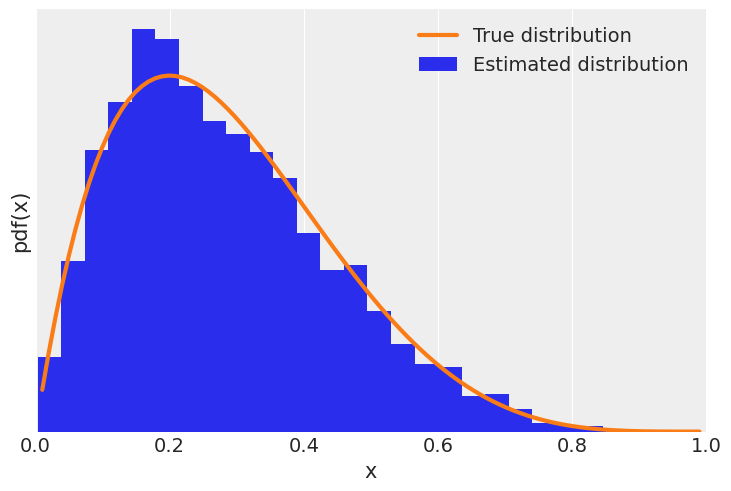

In [10]:
np.random.seed(3)
func = stats.beta(2, 5) 
trace = metropolis(func=func) 
x = np.linspace(0.01, .99, 100) 
y = func.pdf(x) 
plt.xlim(0, 1) 
plt.plot(x, y, 'C1-', lw=3, label='True distribution') 
plt.hist(trace[trace > 0], bins=25, density=True, label='Estimated distribution') 
plt.xlabel('x') 
plt.ylabel('pdf(x)')
plt.yticks([]) 
plt.legend()

### Diagnosing the samples

In [11]:
with pm.Model() as centered_model:
    a = pm.HalfNormal('a', 10)
    b = pm.Normal('b', 0, a, shape = 10)
    idata_cm = pm.sample(2000, random_seed=124, target_accept = 0.9, return_inferencedata=True)
    
with pm.Model() as non_centered_model:
    a = pm.HalfNormal('a', 10)
    
    b_offset = pm.Normal('b_offset', 0, 1, shape = 10)
    b = pm.Deterministic('b', 0+b_offset*a)
    idata_ncm = pm.sample(2000, random_seed = 124, target_accept = 0.9, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 39 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7542127140587811, but should be close to 0.9. Try to increase the number of tuning steps.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7353944158057356, but should be close to 0.9. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_offset, a]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 38 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>]], dtype=object)

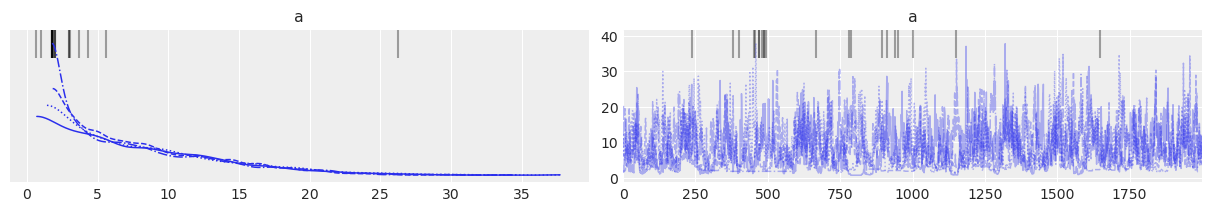

In [12]:
az.plot_trace(idata_cm, var_names=['a'], divergences='top')

array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>]], dtype=object)

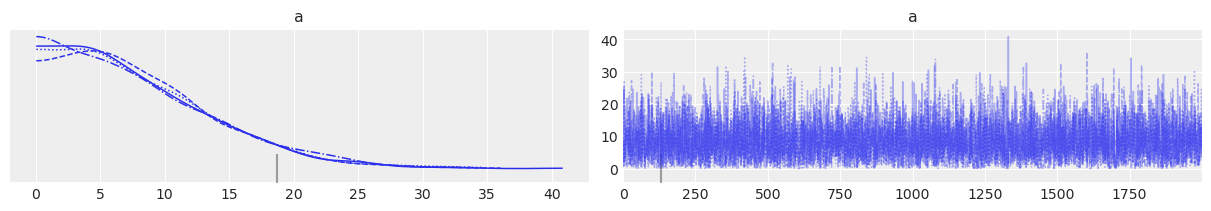

In [13]:
az.plot_trace(idata_ncm, var_names=['a'])

보통 chain들에 따른 plot이 서로 비슷해야 샘플링이 잘 된것으로 볼 수 있다.  
첫번째의 경우 샘플링이 어느정도 잘못되었다.

In [14]:
az.rhat(idata_cm)['a'].values

array(1.02268054)

array([<AxesSubplot:title={'center':'94.0% HDI'}>,
       <AxesSubplot:title={'center':'ess'}>,
       <AxesSubplot:title={'center':'r_hat'}>], dtype=object)

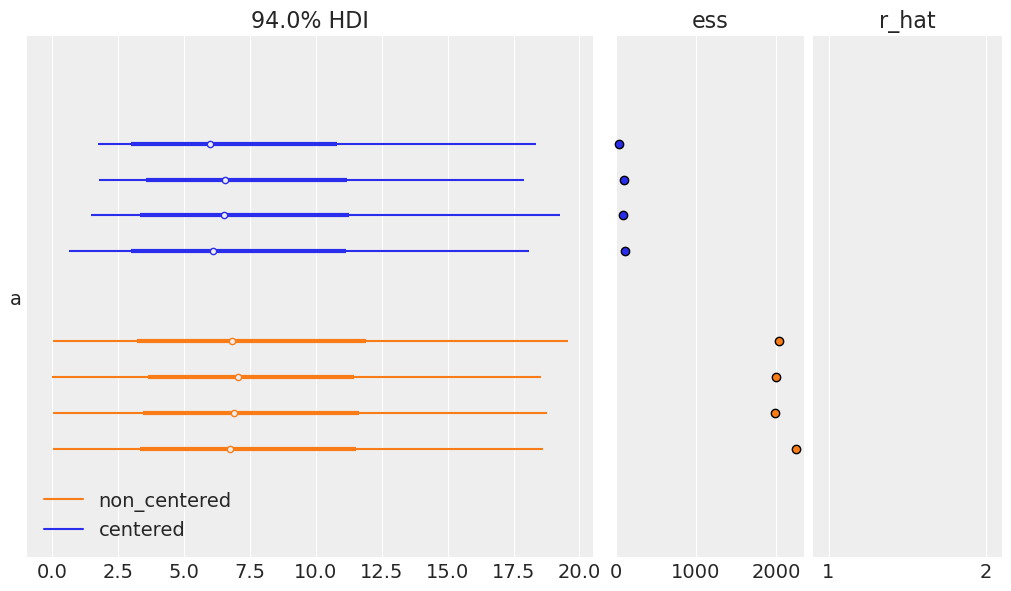

In [15]:
az.plot_forest([idata_cm, idata_ncm], model_names=['centered', 'non_centered'],
               var_names=['a'], r_hat=True, ess=True)

In [16]:
summaries = pd.concat([az.summary(idata_cm, var_names = ['a']),
                       az.summary(idata_ncm, var_names = ['a'])])
summaries.index = ['centered', 'non_centered']
summaries

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
centered,7.839,5.737,0.655,18.440,0.312,0.221,184.0,90.0,1.02
non_centered,8.107,6.044,0.012,18.881,0.066,0.047,5984.0,3081.0,1.00


array([<AxesSubplot:title={'center':'a\n0'}>,
       <AxesSubplot:title={'center':'a\n1'}>,
       <AxesSubplot:title={'center':'a\n2'}>,
       <AxesSubplot:title={'center':'a\n3'}>], dtype=object)

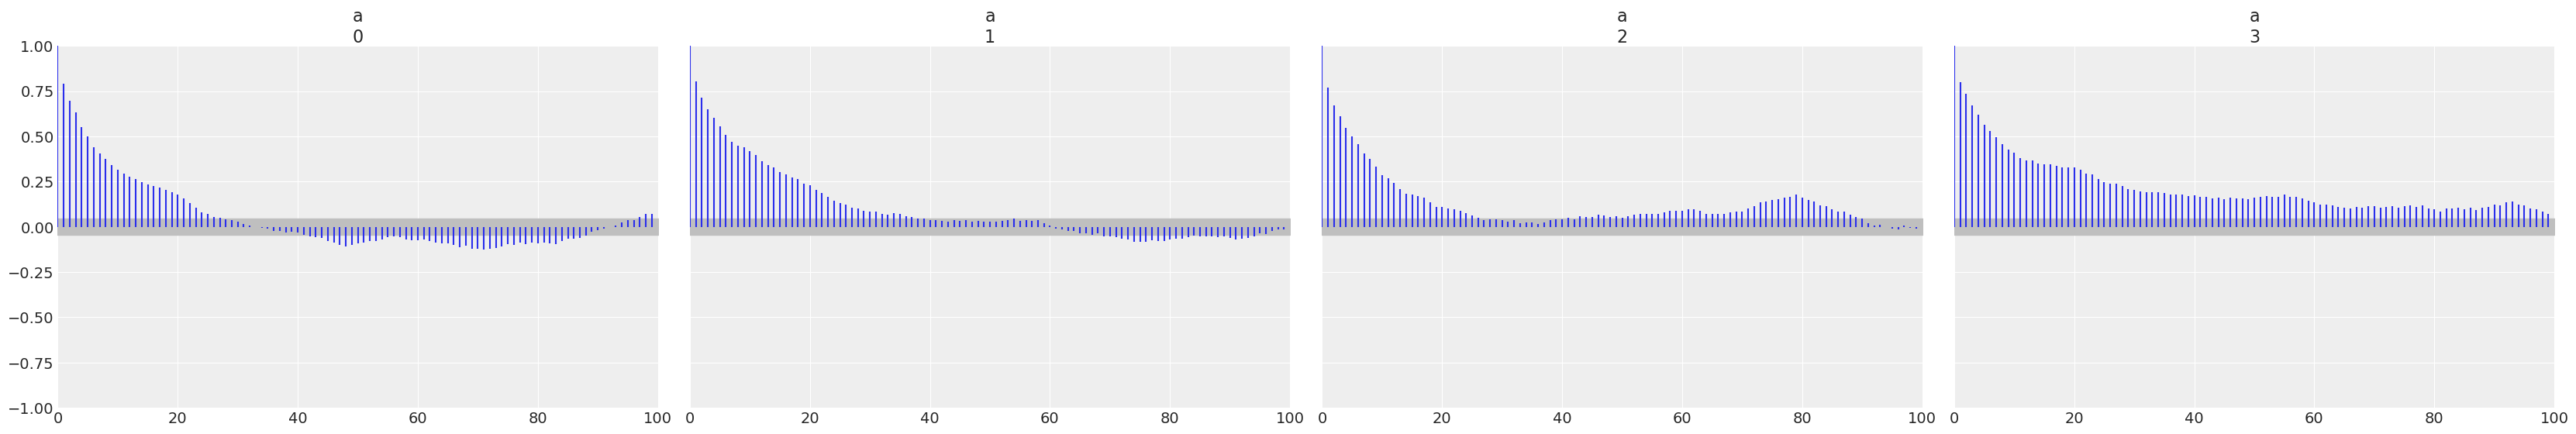

In [17]:
az.plot_autocorr(idata_cm, var_names=['a'])

array([<AxesSubplot:title={'center':'a\n0'}>,
       <AxesSubplot:title={'center':'a\n1'}>,
       <AxesSubplot:title={'center':'a\n2'}>,
       <AxesSubplot:title={'center':'a\n3'}>], dtype=object)

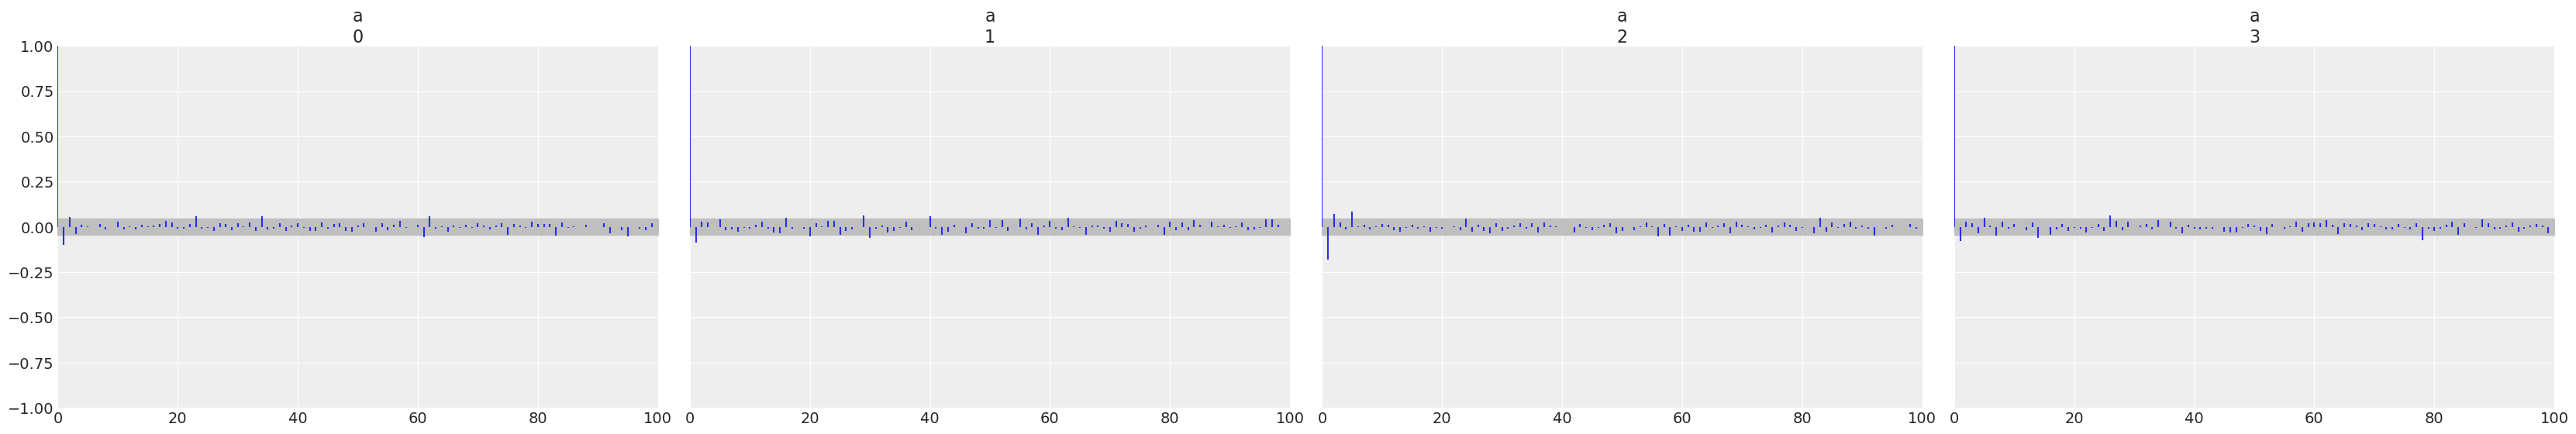

In [18]:
az.plot_autocorr(idata_ncm, var_names=['a'])

autocorrleation그림을 통해 두번째 모델이 조금 더 샘플링이 더 잘 된 것을 알 수 있다.

### Effective sample sizes

In [19]:
az.ess(idata_cm)['a'].values

array(183.96701708)

### Divergence

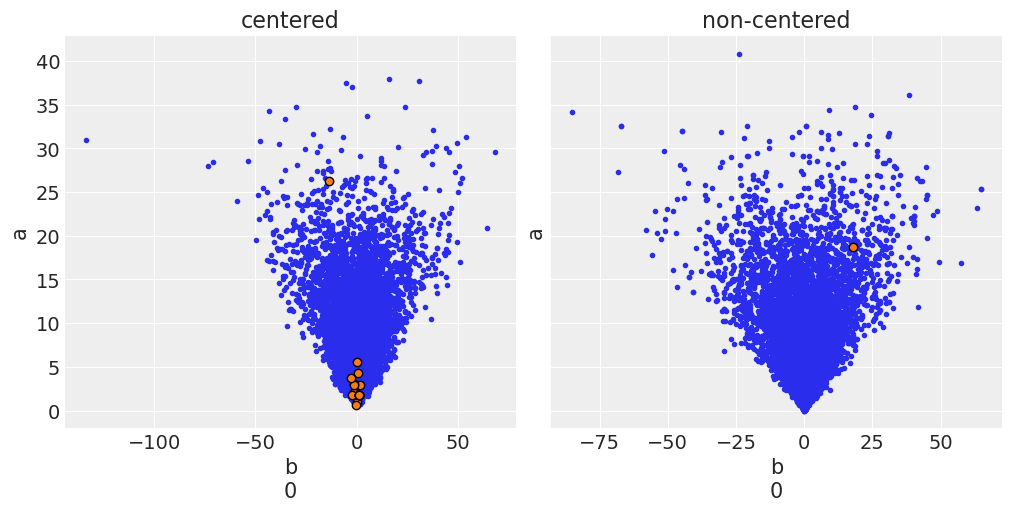

In [20]:
_, ax = plt.subplots(1, 2, sharey=True, figsize = (10, 5), constrained_layout = True)

for idx, tr in enumerate([idata_cm, idata_ncm]):
    az.plot_pair(tr, var_names=['b', 'a'], coords={'b_dim_0' : [0]}, kind='scatter',
                divergences=True, contour=False, divergences_kwargs={'color' : 'C1'},
                ax = ax[idx])
    ax[idx].set_title(['centered', 'non-centered'][idx])

<AxesSubplot:>

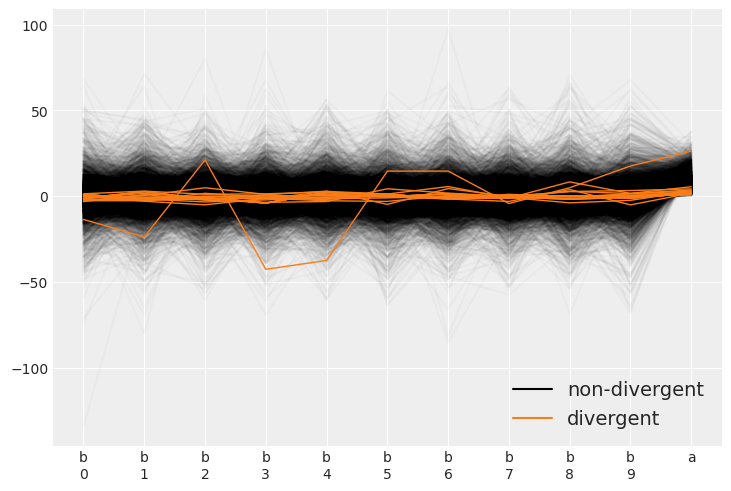

In [21]:
az.plot_parallel(idata_cm)

다음 2개의 그림을 보면 centered의 경우 중심을 기준으로 Divergence가 발생해서, parameter space에서 어느 부분이 문제가 되는 지 확인가능하다.  
다음과 같은 확률 분포의 경우 중심에서 problematic하다.